<div style="text-align: center;">

<img src="doc/fac-sciences-eco_logo2.png" alt="Logo de la Faculté" width="300">

<h1 style="margin-top: 200px; margin-bottom: 150px;">Étude de l’impact du VIX sur le marché boursier Européen</h1>
<h2 style="margin-top: 0px; margin-bottom: 210px;">Advanced Econometrics</h2>

<p style="text-align: center;">
  <strong>Étudiants :</strong><br>
  BOULMEDAIS Sam<br>
  PHALIER Noé
</p>

<p style="text-align: center;">
  <strong>Professeur :</strong><br>
  RONDEAU Fabien
</p>

<p style="text-align: center; margin-bottom: 120px;">
  <strong>Date :</strong> Novembre 2025
</p>

</div>

<!-- Sommaire -->
<h2 style="text-align: center;">Sommaire</h2>

<div style="height: 50px;"></div> <!-- espace sous le titre -->

<ul style="margin-bottom: 240px;">
  <li>Introduction 
    <li>Objectif et méthodologie</li>
    <li>1. Importation des packages</li>
    <li>2. Les données
      <ul>
        <li>2.1 Importation des données</li>
        <li>2.2 Analyse graphique</li>
      </ul>
    </li>
    <li>3. Stationnarité & Cointégration
      <ul>
        <li>3.1 Les tests de stationnarité</li>
        <li>3.2 Tests de stationnarité sur les séries brutes</li>
        <li>3.3 Sélection du nombre optimal de retards (lags) pour le modèle VAR sous-jacent</li>
        <li>3.4 Test de cointégration de Johansen</li>
      </ul>
    </li>
    <li>4. VECM
      <ul>
        <li>4.1 Estimation du modèle VECM</li>
        <li>4.2 Impulse Response Function (IRF)</li>
        <li>4.3 Conclusion du modèle VECM</li>
      </ul>
    </li>
    <li>5. Stationnarisation
      <ul>
        <li>5.1 Transformation des séries</li>
        <li>5.2 Tests de stationnarité sur les séries transformées</li>
        <li>5.3 Visualisation graphique des séries stationnaires</li>
      </ul>
    </li>
    <li>6. SVAR
      <ul>
        <li>6.1 Sélection du nombre optimal de retards (lags)</li>
        <li>6.2 Tests usuels
          <ul>
            <li>6.2.1 Test de Portmanteau</li>
            <li>6.2.2 Test de Breusch-Godfrey</li>
            <li>6.2.3 Test de loi normale</li>
            <li>6.2.4 Résultats des tests usuels</li>
          </ul>
        </li>
        <li>6.3 Estimation du modèle SVAR</li>
      </ul>
    </li>
  </li>
</ul>

## Introduction

La volatilité occupe une place centrale dans l’analyse des marchés financiers. Elle traduit le degré d’incertitude et d’instabilité perçu par les investisseurs. Elle constitue souvent un signal clé des mouvements à venir sur les marchés mondiaux.  

Dans ce contexte, ce projet a pour objectif d’étudier l’influence de la volatilité du marché financier américain, mesurée par l’indice **VIX**, sur la performance du marché boursier européen, représentée par l’indice **EuroStoxx 50**.  

**Le VIX : un baromètre de l’incertitude mondiale**.  

Le **VIX** (*Volatility Index*), élaboré par le **Chicago Board Options Exchange (CBOE)**, mesure la volatilité implicite des options sur le **S&P 500**. Souvent surnommé « *indice de la peur* », le VIX reflète les anticipations des investisseurs concernant les fluctuations du marché à court terme :  
- Une **hausse du VIX** traduit une montée de l’aversion au risque et une augmentation de l’incertitude.  
- Une **baisse du VIX** signale, au contraire, un climat de confiance et une stabilité perçue.  

**L’EuroStoxx 50 : reflet du marché européen**.  

L’**EuroStoxx 50** regroupe les **50 plus grandes capitalisations boursières** de la zone euro. Il constitue un **indice de référence** pour évaluer la performance des marchés actions européens et pour suivre la conjoncture économique de la région.  

## Objectif et méthodologie  

Ce travail vise à **analyser la manière dont les variations du VIX influencent la dynamique du marché européen**, en mettant en évidence la **transmission de la volatilité américaine vers l’Europe**.  

Pour enrichir l’analyse, plusieurs **variables macroéconomiques européennes** sont intégrées :  
- le **taux de chômage** de la zone Euro,  
- le **taux directeur** de la BCE,  
- la **production industrielle** de la zone Euro,  
- et le **taux de change EUR/USD**.  

La méthodologie s’appuie initialement sur l’estimation d’un modèle **SVAR (Structural Vector AutoRegression)**, afin d’examiner les interrelations entre ces variables et d’identifier les effets structurels de la volatilité sur la performance boursière, tout en laissant la possibilité d’adapter cette approche au fur et à mesure de l’avancement du projet. 

*Problématique : Dans quelle mesure la volatilité des marchés financiers américains, telle que mesurée par le VIX, influence-t-elle la dynamique du marché boursier européen représenté par l’EuroStoxx 50, et comment cette transmission de volatilité interagit-elle avec les principales variables macroéconomiques de la zone euro ?*.  

---

## 1. Importation des packages

### 1.1 Configuration de l'environnement Python

Avant de commencer à travailler avec ce notebook, il est nécessaire de configurer correctement votre environnement Python. Cette étape permet d'assurer que toutes les dépendances sont installées et que le notebook fonctionne de manière isolée et reproductible.

**Étape 1 : Ouvrir le terminal**  
Dans **VS Code**, ouvrez le terminal intégré :  

- **Mac** : `Cmd + J`  

**Étape 2 : Créer un environnement virtuel**  
Un environnement virtuel permet d'isoler les dépendances du projet.  

- **Mac / Linux** :
```bash
python3 -m venv venv
```

* **Windows** :

```bash
python -m venv venv
```

**Étape 3 : Activer l'environnement virtuel**

* **Mac / Linux** :

```bash
source venv/bin/activate
```

* **Windows** :

```bash
venv\Scripts\activate
```

> **Remarque :** Une fois activé, vous devriez voir `(venv)` au début de votre ligne de commande.

**Étape 4 : Installer les dépendances**
Installez toutes les bibliothèques nécessaires en utilisant le fichier `requirements.txt` :

```bash
pip install -r requirements.txt
```

> Cela garantit que toutes les versions des packages sont conformes à ce projet.

**Étape 5 : Sélectionner le kernel Python dans VS Code**
Pour que le notebook utilise l'environnement virtuel :

1. Ouvrez la palette de commandes :

   * **Windows / Linux** : `Ctrl + Shift + P`
   * **Mac** : `Cmd + Shift + P`
2. Tapez `Python: Select Interpreter`
3. Sélectionnez l'environnement virtuel `venv` créé précédemment

**Étape 6 : Prêt à utiliser le notebook**
Patientez que tous les packages s'installent, puis vous pouvez maintenant exécuter les cellules du notebook en toute sécurité.
Toutes les bibliothèques nécessaires sont installées et isolées dans l'environnement virtuel.

### 1.2 Import des packages

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

import yfinance as yf
import taceconomics
taceconomics.api_key = 'sk_o24BhJRqVpIvxVSXX3yiKRGgpDEejmyJ8pfLFX2q22s' #clé API à remplacer par la vôtre

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM

import warnings
warnings.filterwarnings('ignore')

---

## 2. Les données

### 2.1 Importation des données

In [2]:
# date de début des données
start_date = '2007-04-01'

# yfinance
tickers = {
    'VIX': '^VIX',
    'EuroStoxx50': '^STOXX50E',
    'EURUSD': 'EURUSD=X'
}

dic = {}

for name, ticker in tickers.items():
    data = yf.download(ticker, start=start_date, interval='1mo', progress=False)
    dic[name] = data['Close']

# taceconomics
tac_tickers = {
    'IPI': f'ECB/STS_M_Y_PROD_NS0010_4_000/EUZ20?start_date={start_date}',
    'i_rate_EUR': f"ECB/FM_D_EUR_4F_KR_DFR_LEV/EUZ?collapse=M&collapse_mode=end_of_period&start_date={start_date}",
    'u_rate_EUR': f'EUROSTAT/EI_LMHR_M_LM-UN-T-TOT_SA_PC_ACT/EUZ20?start_date={start_date}'
}

for name, ticker in tac_tickers.items():
    data = taceconomics.getdata(ticker)
    data.index = pd.to_datetime(data.index)
    data.columns = [name]
    dic[name] = data

# DataFrame final
data = pd.concat(dic, axis=1).dropna()
data.columns = data.columns.droplevel(1)

data.head() 


,VIX,EuroStoxx50,EURUSD,IPI,i_rate_EUR,u_rate_EUR
2007-04-01,14.220000,4392.339844,1.365206,108.7,2.75,7.7
2007-05-01,13.050000,4512.649902,1.345605,110.4,2.75,7.7
2007-06-01,16.230000,4489.770020,1.353601,110.5,3.00,7.6
2007-07-01,23.520000,4315.689941,1.367204,110.4,3.00,7.6
2007-08-01,23.379999,4294.560059,1.364201,111.0,3.00,7.6


### 2.2 Analyse graphique

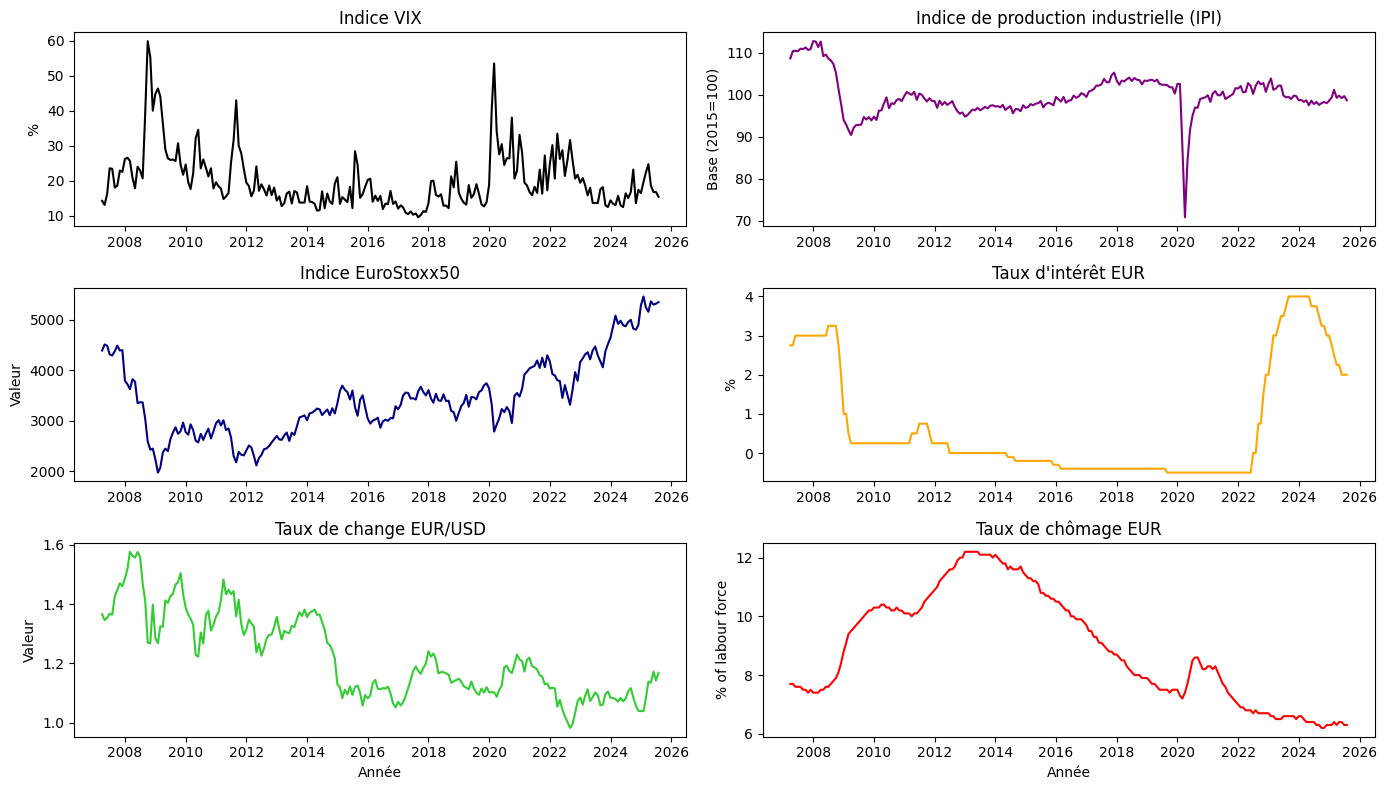

In [3]:
fig, axs = plt.subplots(3,2, figsize=(14, 8))
plt.style.use('default')

axs[0][0].plot(data['VIX'], color='black')
axs[0][0].set_title('Indice VIX')
axs[0][0].set_ylabel('%')

axs[1][0].plot(data['EuroStoxx50'], color='navy')
axs[1][0].set_title('Indice EuroStoxx50')
axs[1][0].set_ylabel('Valeur')

axs[2][0].plot(data['EURUSD'], color='limegreen')
axs[2][0].set_title('Taux de change EUR/USD')
axs[2][0].set_ylabel('Valeur')
axs[2][0].set_xlabel('Année')

axs[0][1].plot(data['IPI'], color='purple')
axs[0][1].set_title('Indice de production industrielle (IPI)')
axs[0][1].set_ylabel('Base (2015=100)')  

axs[1][1].plot(data['i_rate_EUR'], color='orange')
axs[1][1].set_title("Taux d'intérêt EUR")
axs[1][1].set_ylabel('%')

axs[2][1].plot(data['u_rate_EUR'], color='red')
axs[2][1].set_title('Taux de chômage EUR')
axs[2][1].set_ylabel('% of labour force')
axs[2][1].set_xlabel('Année')


plt.tight_layout()
plt.show()

**Analyse de l’évolution du VIX et de l’EuroStoxx 50 (2007–2025)**

Les graphiques présentent l’évolution conjointe du **VIX**, de l’**EuroStoxx 50** et de plusieurs variables macroéconomiques européennes entre 2007 et 2025.

**Tendances générales**

- Le **VIX**, indicateur de la volatilité implicite sur le marché américain, montre des **pics marqués en 2008–2009** (crise financière mondiale) et en **2020** (crise du COVID-19), reflétant une forte incertitude sur les marchés.  
- L’**EuroStoxx 50** réagit systématiquement à ces tensions, avec des baisses importantes lors des pics de volatilité.  
- Le **taux de change EUR/USD** se déprécie progressivement, illustrant la divergence des politiques monétaires entre la BCE et la Fed.

**Corrélation entre VIX et EuroStoxx 50**

L’analyse des courbes du VIX et de l’EuroStoxx 50 met en évidence une **corrélation inverse marquée** :  

- Les périodes de forte hausse du VIX coïncident avec des **baisses significatives** de l’EuroStoxx 50.  
- À l’inverse, lorsque le VIX diminue, le marché boursier européen tend à se **redresser**.

**Épisodes majeurs**

- **2008–2009 :** Crise financière mondiale → explosion du VIX et chute brutale de l’EuroStoxx 50.  
- **2011 :** Nouvelle hausse de la volatilité et recul des marchés européens.  
- **2020 :** Pandémie de COVID-19 → pic historique du VIX et effondrement temporaire de l’EuroStoxx 50.  
- **2022–2024 :** Tensions géopolitiques et remontée de l’inflation → nouveaux accès de volatilité, suivis d’une reprise nette à partir de 2024.

**Interprétation**

Cette relation négative illustre le rôle du **VIX comme baromètre de la confiance des investisseurs** :

- Une **hausse du VIX** traduit une montée de la peur et entraîne une baisse des prix des actions, y compris en Europe.  
- Une **baisse du VIX** indique un retour de la stabilité et favorise la reprise des marchés.

**Conclusion**

Sur la période 2007–2025, la dynamique du VIX permet d’expliquer **une grande partie des fluctuations de l’EuroStoxx 50**. On cherche donc à prouver que l’indice américain de volatilité constitue un **indicateur avancé pertinent** pour anticiper les phases de tension ou de reprise sur les marchés financiers européens.  

---

## 3. Stationnarité & Cointégration

### 3.1 Les tests de stationnarité

Pour tester la stationnarité des séries nous avons réalisé trois tests : ADF, KPSS et Philips Perron.  

**Test ADF** (Augmented Dickey-Fuller)
- **H0 (hypothèse nulle)** : La série **possède une racine unitaire** → **non stationnaire**  
- **H1 (hypothèse alternative)** : La série **n’a pas de racine unitaire** → **stationnaire**  

Interprétation :  
- p-value < 0.05 → rejette H0 → série **stationnaire**  
- p-value ≥ 0.05 → ne rejette pas H0 → série **non stationnaire**  

**Test KPSS**
- **H0 (hypothèse nulle)** : La série **est stationnaire**  
- **H1 (hypothèse alternative)** : La série **n’est pas stationnaire**  

Interprétation :  
- p-value < 0.05 → rejette H0 → série **non stationnaire**  
- p-value ≥ 0.05 → ne rejette pas H0 → série **stationnaire**

**Test Phillips-Perron (PP)**  
- **H0 (hypothèse nulle)** : La série possède une racine unitaire → non stationnaire
- **H1 (hypothèse alternative)** : La série n’a pas de racine unitaire → stationnaire

Interprétation :
- p-value < 0.05 → rejette H0 → série **stationnaire**  
- p-value ≥ 0.05 → ne rejette pas H0 → série **non stationnaire**  

### 3.2 Tests de stationnarité sur les séries brutes

In [ ]:
def test_adf(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Valeurs critiques :")
    for key, value in result[4].items():
        print(f"  {key}: {value}")
    print("\n")

def kpss_test(series):
    result = kpss(series, regression='c')
    print(f"KPSS Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Valeurs critiques :")
    for key, value in result[3].items():
        print(f"  {key}: {value}")
    print("\n")

def philips_perron_test(series):
    pp_test = PhillipsPerron(series)
    print(f"PP Statistic: {pp_test.stat}")
    print(f"p-value: {pp_test.pvalue}")
    print("Valeurs critiques :")
    for key, value in pp_test.critical_values.items():
        print(f"  {key}: {value}")

# on teste la stationnarité des séries originales sur les valeurs 'Close'
for name in data.columns:
    print(f"---------- {name} ----------")
    test_adf(data[name])
    kpss_test(data[name])
    philips_perron_test(data[name])
    print("-----------------------------\n")

**Résultats**

| Série           | ADF (p-value)   | KPSS (p-value) | PP (p-value)    | Stationnaire ?  | Transformation suggérée                      |
| --------------- | --------------- | -------------- | --------------- | --------------- | -------------------------------------------- |
| **VIX**         | 8.1e-06 (<0.05) | 0.074 (≥0.05)  | 1.8e-06 (<0.05) | Oui           | Aucune nécessaire                            |
| **EuroStoxx50** | 0.795 (≥0.05)   | 0.01 (<0.05)   | 0.748 (≥0.05)   | Non           | log (Δ) (Δ)                             |
| **EURUSD**      | 0.305 (≥0.05)   | 0.01 (<0.05)   | 0.385 (≥0.05)   | Non           | log (Δ)  (Δ)                             |
| **IPI**         | 0.007 (<0.05)   | 0.1 (≥0.05)    | 0.008 (<0.05)   | Oui           | Aucune nécessaire                            |
| **i_rate_EUR**  | 0.260 (≥0.05)   | 0.075 (≥0.05)  | 0.340 (≥0.05)   | Non (douteux) | Différencier (Δ) ou tester la 1re différence |
| **u_rate_EUR**  | 0.582 (≥0.05)   | 0.01 (<0.05)   | 0.855 (≥0.05)   | Non           | Différencier (Δ)                             |


### 3.3 Sélection du nombre optimal de retards (lags) pour le modèle VAR sous-jacent

Le nombre optimal de retards (lags) est déterminé à l’aide des critères d’information classiques, notamment les critères AIC et BIC, de façon à capturer les dynamiques temporelles pertinentes sans surparamétrer le modèle.

Le but est de trouver un compromis entre :

- un modèle trop court → mauvaise dynamique (biais d’omission)
- un modèle trop long → perte de degrés de liberté (sur-ajustement)

In [5]:
# lags optimaux selon AIC
model = VAR(data)
lag_order = model.select_order(maxlags=12)
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        15.65       15.75   6.262e+06       15.69
1       -1.344    -0.6726*      0.2608     -1.073*
2       -1.473     -0.2257      0.2294     -0.9687
3       -1.579      0.2438      0.2067     -0.8422
4      -1.611*      0.7883     0.2012*     -0.6407
5       -1.592       1.383      0.2063     -0.3891
6       -1.478       2.072      0.2333    -0.04271
7       -1.509       2.617      0.2292      0.1592
8       -1.414       3.287      0.2564      0.4866
9       -1.289       3.989      0.2974      0.8450
10      -1.184       4.669      0.3398       1.182
11      -1.013       5.416      0.4179       1.586
12     -0.9165       6.088      0.4808       1.915
--------------------------------------------------


### 3.4 Test de cointégration de Johansen

Avant l’estimation d’un modèle structurel, il est nécessaire de vérifier si les variables considérées partagent une relation de **long terme**. En effet, si les séries sont **non stationnaires** mais évoluent de manière liée dans le temps, elles peuvent être **cointégrées**, c’est-à-dire qu’il existe entre elles un **équilibre économique stable à long terme**. Dans ce cas, l’utilisation d’un modèle à **correction d’erreur (VECM)** est plus appropriée qu’un VAR ou SVAR.

Le **test de cointégration de Johansen** permet de déterminer l’existence et le nombre de relations de cointégration dans un système multivarié. Il repose sur la réécriture d’un modèle VAR sous forme de VECM, dans lequel la **matrice des coefficients de long terme** indique la présence éventuelle de relations de cointégration entre les variables.

Le **rang** de cette matrice correspond au nombre de relations de long terme :

* Si ( r = 0 ), il n’existe **aucune relation de cointégration**.
* Si ( r > 0 ), les variables sont liées par ( r ) **relations d’équilibre**.

Deux statistiques sont utilisées pour déterminer le nombre de relations de cointégration :

* **Test de la trace (trace test)**
* **Test de la valeur propre maximale (maximum eigenvalue test)**

Ces tests permettent d’identifier combien de relations de cointégration sont présentes dans le système.

Dans le cadre de ce projet, le test de Johansen est appliqué aux six variables du modèle SVAR :

* EuroStoxx 50
* VIX
* Taux de chômage
* Taux d’intérêt
* Indice de production industrielle (IPI)
* Taux de change EUR/USD

Ce test permet de déterminer si ces variables présentent une **tendance commune à long terme** et d’adapter en conséquence la **spécification du modèle**.

In [ ]:
def johansen_test(data, det_order=0, k_ar_diff=1):
    test = coint_johansen(data, det_order, k_ar_diff)
    return {
        "trace_stat": test.lr1,
        "trace_crit": test.cvt,
        "max_eig_stat": test.lr2,
        "max_eig_crit": test.cvm
    }

print("----- Test de cointégration de Johansen avec 4 retards -----")
johansen_results = johansen_test(data, det_order=0, k_ar_diff=4)
print("Statistiques de trace :", johansen_results["trace_stat"])
print("Valeurs critiques de trace :\n", johansen_results["trace_crit"])
print("Statistiques de max-eigenvalue :", johansen_results["max_eig_stat"])
print("Valeurs critiques de max-eigenvalue :\n", johansen_results["max_eig_crit"])
print("------------------------------------------------------------")

**Résultats**

**Test de la trace**

| Rang (r) | trace_stat | Valeur critique 5% | Rejet H0 ? |
| -------- | ---------- | ------------------ | ---------- |
| 0        | 125.11    | 95.7542            | Oui        |
| 1        | 80.70      | 69.8189            | Oui   ←    |
| 2        | 45.87      | 47.8545            | Non        |
| 3        | 22.57    | 29.7961            | Non        |
| 4        | 5.73       | 15.4943            | Non        |
| 5        | 0.50       | 3.8415             | Non        |

**Test de max-eigenvalue**

| Rang (r) | max-eig_stat | Valeur critique 5% | Rejet H0 ? |
| -------- | ------------ | ------------------ | ---------- |
| 0        | 44.40        | 40.0763            | Oui        |
| 1        | 34.83        | 33.8777            | Oui   ←    |
| 2        | 23.30       | 27.5858            | Non        |
| 3        | 16.83        | 21.1314            | Non        |
| 4        | 5.23         | 14.2639            | Non        |
| 5        | 0.50         | 3.8415             | Non        |

**Conclusion**

- On rejette H0 pour r = 0 et r = 1 → donc 2 relations de cointégration.
- Les 6 variables étudiées sont cointégrées avec 2 relations de long terme.
- Cela signifie qu’il existe 2 équilibres économiques stables liant ces variables à long terme.  

Nous allons donc finalement opter pour un modèle VECM plutôt qu'un SVAR prévu initialement. En effet, les tests de cointégration de Johansen ont montré que les variables sont liées par deux relations de long terme, ce qui implique la présence d’équilibres stables à long terme que le modèle VECM est capable de capturer, contrairement à un SVAR classique.  

---

## 4. VECM

### 4.1 Estimation du modèle VECM

On procède donc à l'estimation du modèle VECM avec **2 relations de cointégration et un nombre optimal de retards de 24 lags**.  

In [7]:
def fit_vecm(data, k_ar_diff=24, coint_rank=2, deterministic="ci"):
    vecm_model = VECM(data, k_ar_diff=k_ar_diff, coint_rank=coint_rank, deterministic=deterministic)
    vecm_res = vecm_model.fit()
    return vecm_res

vecm_results = fit_vecm(data, deterministic="ci")

### 4.2 Impulse Response Function (IRF)

Pour pouvoir étudier l’impact d’un **choc du VIX sur l’Eurostoxx**, on utilise une **IRF** (*Impulse Response Function*).

Une **fonction de réponse impulsionnelle (IRF)** est un outil d’analyse dynamique utilisé dans les modèles **VAR** et **VECM** pour mesurer l’effet d’un **choc exogène** sur une variable donnée, ainsi que sur l’ensemble des autres variables du système au fil du temps.

Concrètement, elle permet d’observer **comment une variable réagit dans les périodes suivantes** à une **perturbation temporaire** sur une autre variable, tout en tenant compte des **interdépendances** entre toutes les composantes du modèle.

L’IRF met en évidence **la direction** et **la durée de l’impact** d’un choc, permettant d’évaluer **la vitesse d’ajustement du système économique** après une perturbation.


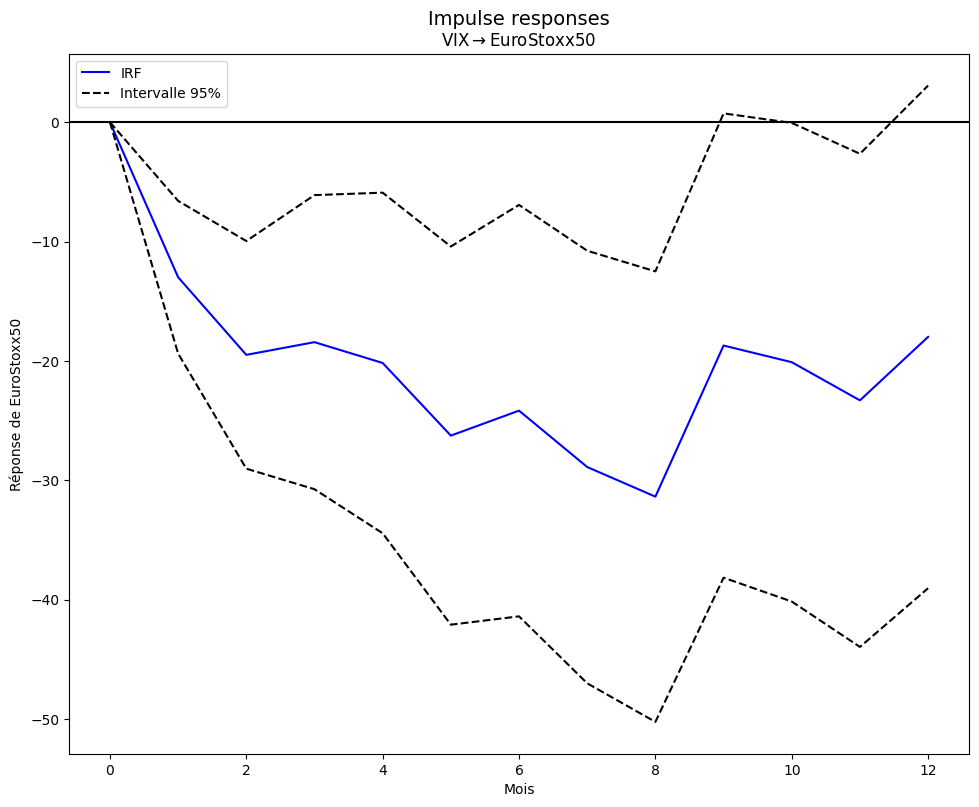

In [8]:
def impulse_response(vecm_res, steps=12):
    irf = vecm_res.irf(steps)
    # irf.plot(orth=False)
    irf.plot(impulse='VIX', response='EuroStoxx50', figsize=(10,8))
    plt.xlabel('Mois')
    plt.ylabel('Réponse de EuroStoxx50')
    plt.legend(['IRF', 'Intervalle 95%'])
    plt.show()

irf = impulse_response(vecm_results)
irf

**Analyse de l'IRF : VIX → EuroStoxx50**

La **fonction de réponse impulsionnelle (IRF)** montre qu’un **choc positif du VIX** entraîne une **baisse immédiate** de l’indice **EuroStoxx 50**.  
Cette réaction négative persiste durant **les deux premiers mois** suivant le choc, traduisant une **forte sensibilité du marché boursier européen** à une hausse de la volatilité sur le marché américain.

À partir du **troisième mois**, l’EuroStoxx 50 se **stabilise à un niveau inférieur**, suggérant une **phase d’ajustement** du marché après la réaction initiale.

En somme, l’impact du VIX sur l’EuroStoxx 50 apparaît **négatif, immédiat et transitoire**, confirmant la **transmission rapide mais temporaire** des chocs de volatilité américains vers le marché européen.

### 4.3 Conclusion du modèle VECM

Le **modèle VECM estimé**, intégrant l’**EuroStoxx 50**, le **VIX**, le **taux de change EUR/USD**et les **variables macroéconomiques européennes**, met en évidence **deux relations de cointégration** entre ces variables.  
Cela confirme l’existence de **liens de long terme** entre la **volatilité américaine**, les **conditions macroéconomiques européennes** et les **performances du marché boursier européen**.

L’analyse de la **fonction de réponse impulsionnelle** montre que les **chocs de volatilité (VIX)** ont un **effet négatif et significatif à court terme** sur l’EuroStoxx 50, suivi d’une **stabilisation progressive** du marché à moyen terme.  
Ces résultats soulignent la **vulnérabilité du marché européen** face aux **tensions de volatilité internationales**, tout en mettant en lumière sa **capacité d’ajustement dans le temps**.

Ainsi, le **modèle VECM** permet de **capturer efficacement la dynamique conjointe** entre les **marchés financiers** et les **variables macroéconomiques**.


---

## 5. Stationnarisation

Nous procédons à la stationnarisation des séries non-stationnaires préalablement à la réalisation d'un modèle SVAR.

* Pour le VIX et l'IPI, on ne fait rien car elles sont déjà stationnaires voir la partie 3.2.
* Pour l'EuroStoxx50 et le taux de change EURUSD, on utilise les rendements logarithmiques.
* Pour les variables macroéconomiques du taux d'intérêt et du taux de chômage, on utilise la première différence.

### 5.1 Transformation des séries

In [9]:
log_returns = np.log(data[["EuroStoxx50","EURUSD"]]).diff()
log_returns.columns = [f"log_return_{col}" for col in log_returns.columns]

diff = data[["i_rate_EUR","u_rate_EUR"]].diff()
diff.columns = [f"diff_{col}" for col in diff.columns]

# création du DataFrame final avec les transformations et suppression des NA
df_final = pd.concat([log_returns, diff, data[["VIX","IPI"]]], axis=1).dropna()
df_final.head()

,log_return_EuroStoxx50,log_return_EURUSD,diff_i_rate_EUR,diff_u_rate_EUR,VIX,IPI
2007-05-01,0.027022,-0.014462,0.00,0.0,13.050000,110.4
2007-06-01,-0.005083,0.005925,0.25,-0.1,16.230000,110.5
2007-07-01,-0.039544,0.009999,0.00,0.0,23.520000,110.4
2007-08-01,-0.004908,-0.002199,0.00,0.0,23.379999,111.0
2007-09-01,0.020090,0.045007,0.00,-0.1,18.000000,110.9


### 5.2 Tests de stationnarité sur les séries transformées

On refais les tests de stationnarité sur nos séries transformées.

In [ ]:
cols_to_test = ["log_return_EuroStoxx50", "log_return_EURUSD", "diff_i_rate_EUR", "diff_u_rate_EUR"]

for name in cols_to_test:
    print(f"----- {name} -----")
    test_adf(df_final[name])
    kpss_test(df_final[name])
    philips_perron_test(df_final[name])
    print("-----------------\n")

**Résultats**

| Série                    | Test ADF (p-value)        | Test KPSS (p-value)  | Test PP (p-value)           | Stationnaire ? |
|---------------------------|---------------------------|----------------------|-----------------------------|----------------|
| **log_return_EuroStoxx50** | 8.89e-13                 | 0.10                 | 3.74e-26                    | Oui |
| **log_return_EURUSD**      | 1.64e-27                 | 0.10                 | 7.53e-28                    | Oui |
| **diff_i_rate_EUR**        | 6.61e-05                 | 0.10                 | 6.77e-21                    | Oui |
| **diff_u_rate_EUR**        | 0.0527                   | 0.0227               | 3.74e-19                    | On conclu que oui car ça ne serait plus pertinent de différencier la série une seconde fois |


### 5.3 Visualisation graphique des séries stationnaires

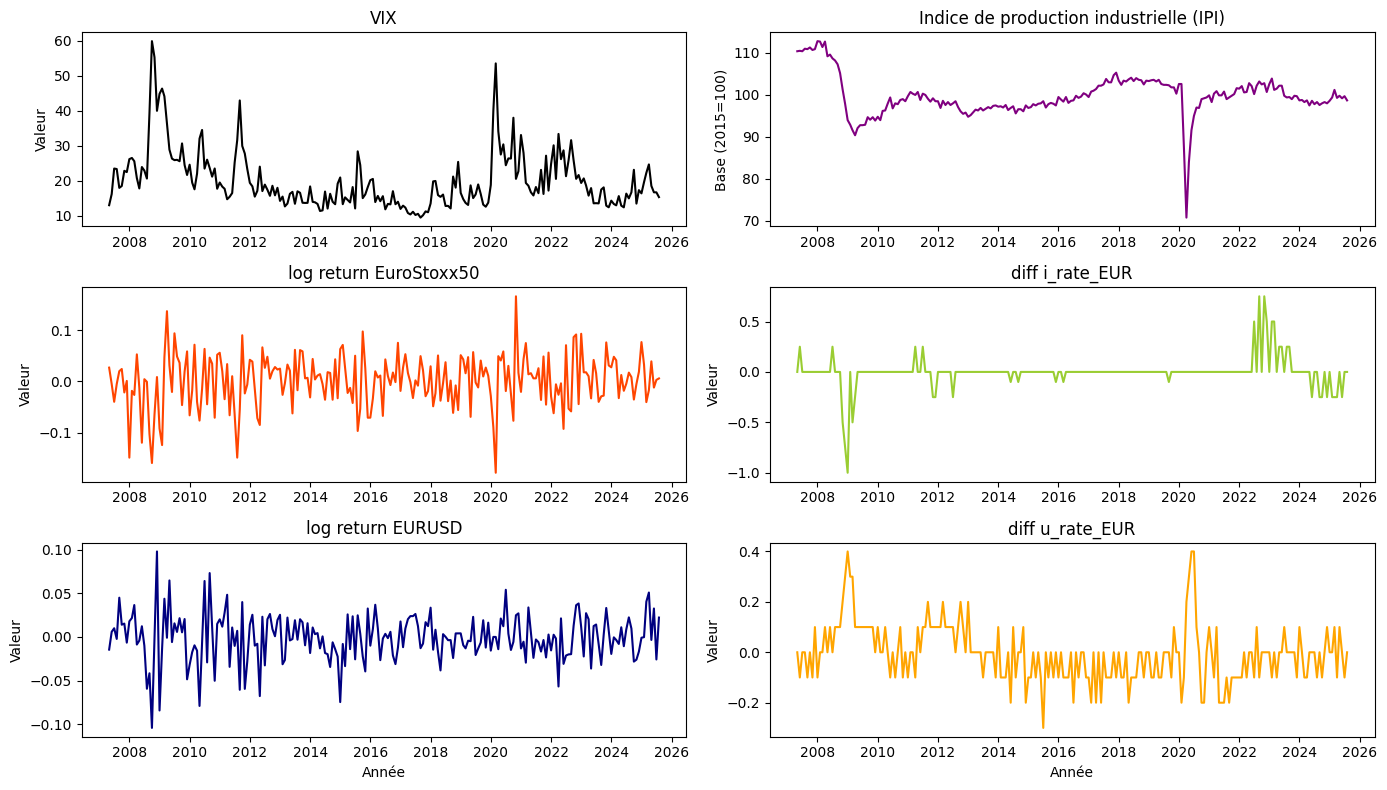

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(14, 8))

axs[0][0].plot(df_final['VIX'], color='black')
axs[0][0].set_title('VIX')
axs[0][0].set_ylabel('Valeur')

axs[1][0].plot(df_final['log_return_EuroStoxx50'], color='orangered')
axs[1][0].set_title('log return EuroStoxx50')
axs[1][0].set_ylabel('Valeur')

axs[2][0].plot(df_final['log_return_EURUSD'], color='navy')
axs[2][0].set_title('log return EURUSD')
axs[2][0].set_ylabel('Valeur')
axs[2][0].set_xlabel('Année')

axs[0][1].plot(df_final['IPI'], color='purple')
axs[0][1].set_title('Indice de production industrielle (IPI)')
axs[0][1].set_ylabel('Base (2015=100)')

axs[1][1].plot(df_final['diff_i_rate_EUR'], color='yellowgreen')
axs[1][1].set_title('diff i_rate_EUR')
axs[1][1].set_ylabel('Valeur')

axs[2][1].plot(df_final['diff_u_rate_EUR'], color='orange')
axs[2][1].set_title("diff u_rate_EUR")
axs[2][1].set_ylabel('Valeur')
axs[2][1].set_xlabel('Année')

plt.tight_layout()
plt.show()

---

## 6. SVAR

### 6.1 Sélection du nombre optimal de retards (lags)

Le nombre optimal de retards (lags) est déterminé à l’aide des critères d’information classiques, notamment les critères AIC et BIC, de façon à capturer les dynamiques temporelles pertinentes sans surparamétrer le modèle.

Le but est de trouver un compromis entre :

- un modèle trop court → mauvaise dynamique (biais d’omission)

- un modèle trop long → perte de degrés de liberté (sur-ajustement)

In [26]:
# lags optimaux selon AIC
model = VAR(df_final)
var_res = model.fit(4)

lag_order = model.select_order(maxlags=12, trend='n')  # aucune constante ni tendance car les séries sont stationnaires
print(lag_order.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -17.74      -17.16   1.977e-08      -17.51
1       -17.96     -16.80*   1.591e-08     -17.49*
2       -18.01      -16.28   1.506e-08      -17.31
3      -17.95*      -15.64  1.605e-08*      -17.02
4       -17.95      -15.06   1.628e-08      -16.78
5       -17.91      -14.45   1.694e-08      -16.51
6       -17.88      -13.84   1.769e-08      -16.25
7       -17.79      -13.17   1.979e-08      -15.92
8       -17.62      -12.42   2.401e-08      -15.52
9       -17.45      -11.67   2.923e-08      -15.11
10      -17.34      -10.99   3.360e-08      -14.78
11      -17.39      -10.46   3.360e-08      -14.58
--------------------------------------------------


### 6.2 Tentative d’estimation d’un modèle SVAR

Après avoir estimé un **modèle VECM** pour analyser la relation entre le **VIX** et l’**EuroStoxx 50**, nous avons souhaité approfondir notre étude en mettant en œuvre un **modèle SVAR (Structural Vector Autoregression)**.

**Pourquoi un SVAR ?**

L’idée principale derrière l’utilisation d’un **SVAR** était de **mieux identifier les relations structurelles** entre nos variables, en allant au-delà des simples corrélations dynamiques captées par le VECM.
En effet :

* Le **VECM** permet d’analyser les relations de **long terme** entre les séries, c’est-à-dire les équilibres de long terme entre les variables.
* Le **SVAR**, quant à lui, permet d’**imposer des contraintes structurelles** issues de la théorie économique afin d’interpréter les **chocs exogènes** et leur **causalité** sur les variables du système.

Notre objectif était donc de **comparer les résultats du SVAR à ceux du VECM**, notamment pour vérifier si la **suppression de la tendance de long terme** pouvait modifier la dynamique des interactions entre le **VIX** et l’**EuroStoxx 50**.

**Difficultés rencontrées**

Malheureusement, la mise en œuvre du modèle SVAR n’a pas pu aboutir.
Nous avons rencontré un **problème technique lié au package utilisé**, qui empêchait la création correcte du modèle. Malgré plusieurs tentatives (réinstallation des packages, essai avec d'autre suggestions faites par IA ...), **le SVAR n’a pas pu être estimé**.

Ainsi, notre analyse comparative entre le VECM et le SVAR n’a pas pu être réalisée comme prévu, ce qui constitue une **limite technique** de notre étude.

Nous avons également essayé en dernier recours de finir ce projet sur R afin d'obtenir de potentiels résultats qui seraient venus compléter notre analyse, mais par manque de temps, nous avons préfére ne pas inclure cette partie pour éviter de gâcher le travail réalisé avec un complément peu élaboré.

---

## 7. Conclusion générale du projet

Ce projet nous a permis d’explorer la **relation entre la volatilité américaine (VIX)** et la **performance du marché européen (EuroStoxx 50)** à travers une approche économétrique rigoureuse.

L’estimation du **modèle VECM** a montré qu’il existe une **interaction significative** entre les deux indices, confirmant que les **chocs de volatilité aux États-Unis** ont un **impact mesurable sur les marchés européens**. Cette relation illustre bien la **forte interdépendance financière** entre les grandes places boursières mondiales.

Même si la partie **SVAR** n’a pas pu être menée à terme, cette tentative a enrichi notre compréhension des **approches structurelles** en économétrie des séries temporelles. Elle a également mis en évidence l’importance des **aspects techniques et logiciels** dans la réalisation d’une analyse économétrique complète.

En conclusion, ce projet a permis de :

* Démontrer le **rôle central de la volatilité** américaine dans la dynamique des marchés européens
* Mettre en œuvre des **outils économétriques avancés** (VECM, tentative de SVAR) pour analyser ces interactions
